In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report

import pandas as pd
from PIL import Image
import os
from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import Dataset

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
sample_path = "/content/drive/MyDrive/CSC480-Project/train-metadata.csv"

#sample_meta = pd.read_csv(os.path.join(sample_path, "train_metadata_first100.csv"))

#image_folder = os.path.join(sample_path, "train_images_first100")

#sample_file_names = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
df_meta = pd.read_csv(sample_path)

<ipython-input-81-04ad5d34516e>:8: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(sample_path)


In [82]:
# df_meta = df_meta.sample(n=200000)

In [83]:
df_meta.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


#Dropping Unecessary Columns

In [84]:
dropped_features = ['isic_id', 'patient_id', 'image_type', 'tbp_tile_type', 'tbp_lv_nevi_confidence' ,'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']
X = df_meta.drop(columns=dropped_features + ['target'])
y = df_meta['target']

In [85]:
# DEBUGGING

print(X.columns)

Index(['age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm',
       'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C',
       'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
       'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean',
       'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z'],
      dtype='object')


#Preparation and Analytics

In [86]:
categorical = X.select_dtypes(include=['object']).columns
numerical = X.select_dtypes(exclude=['object']).columns
X[numerical]= X[numerical].fillna(0)
X[categorical]= X[categorical].fillna('NA')

##Looking at Feature Correlation

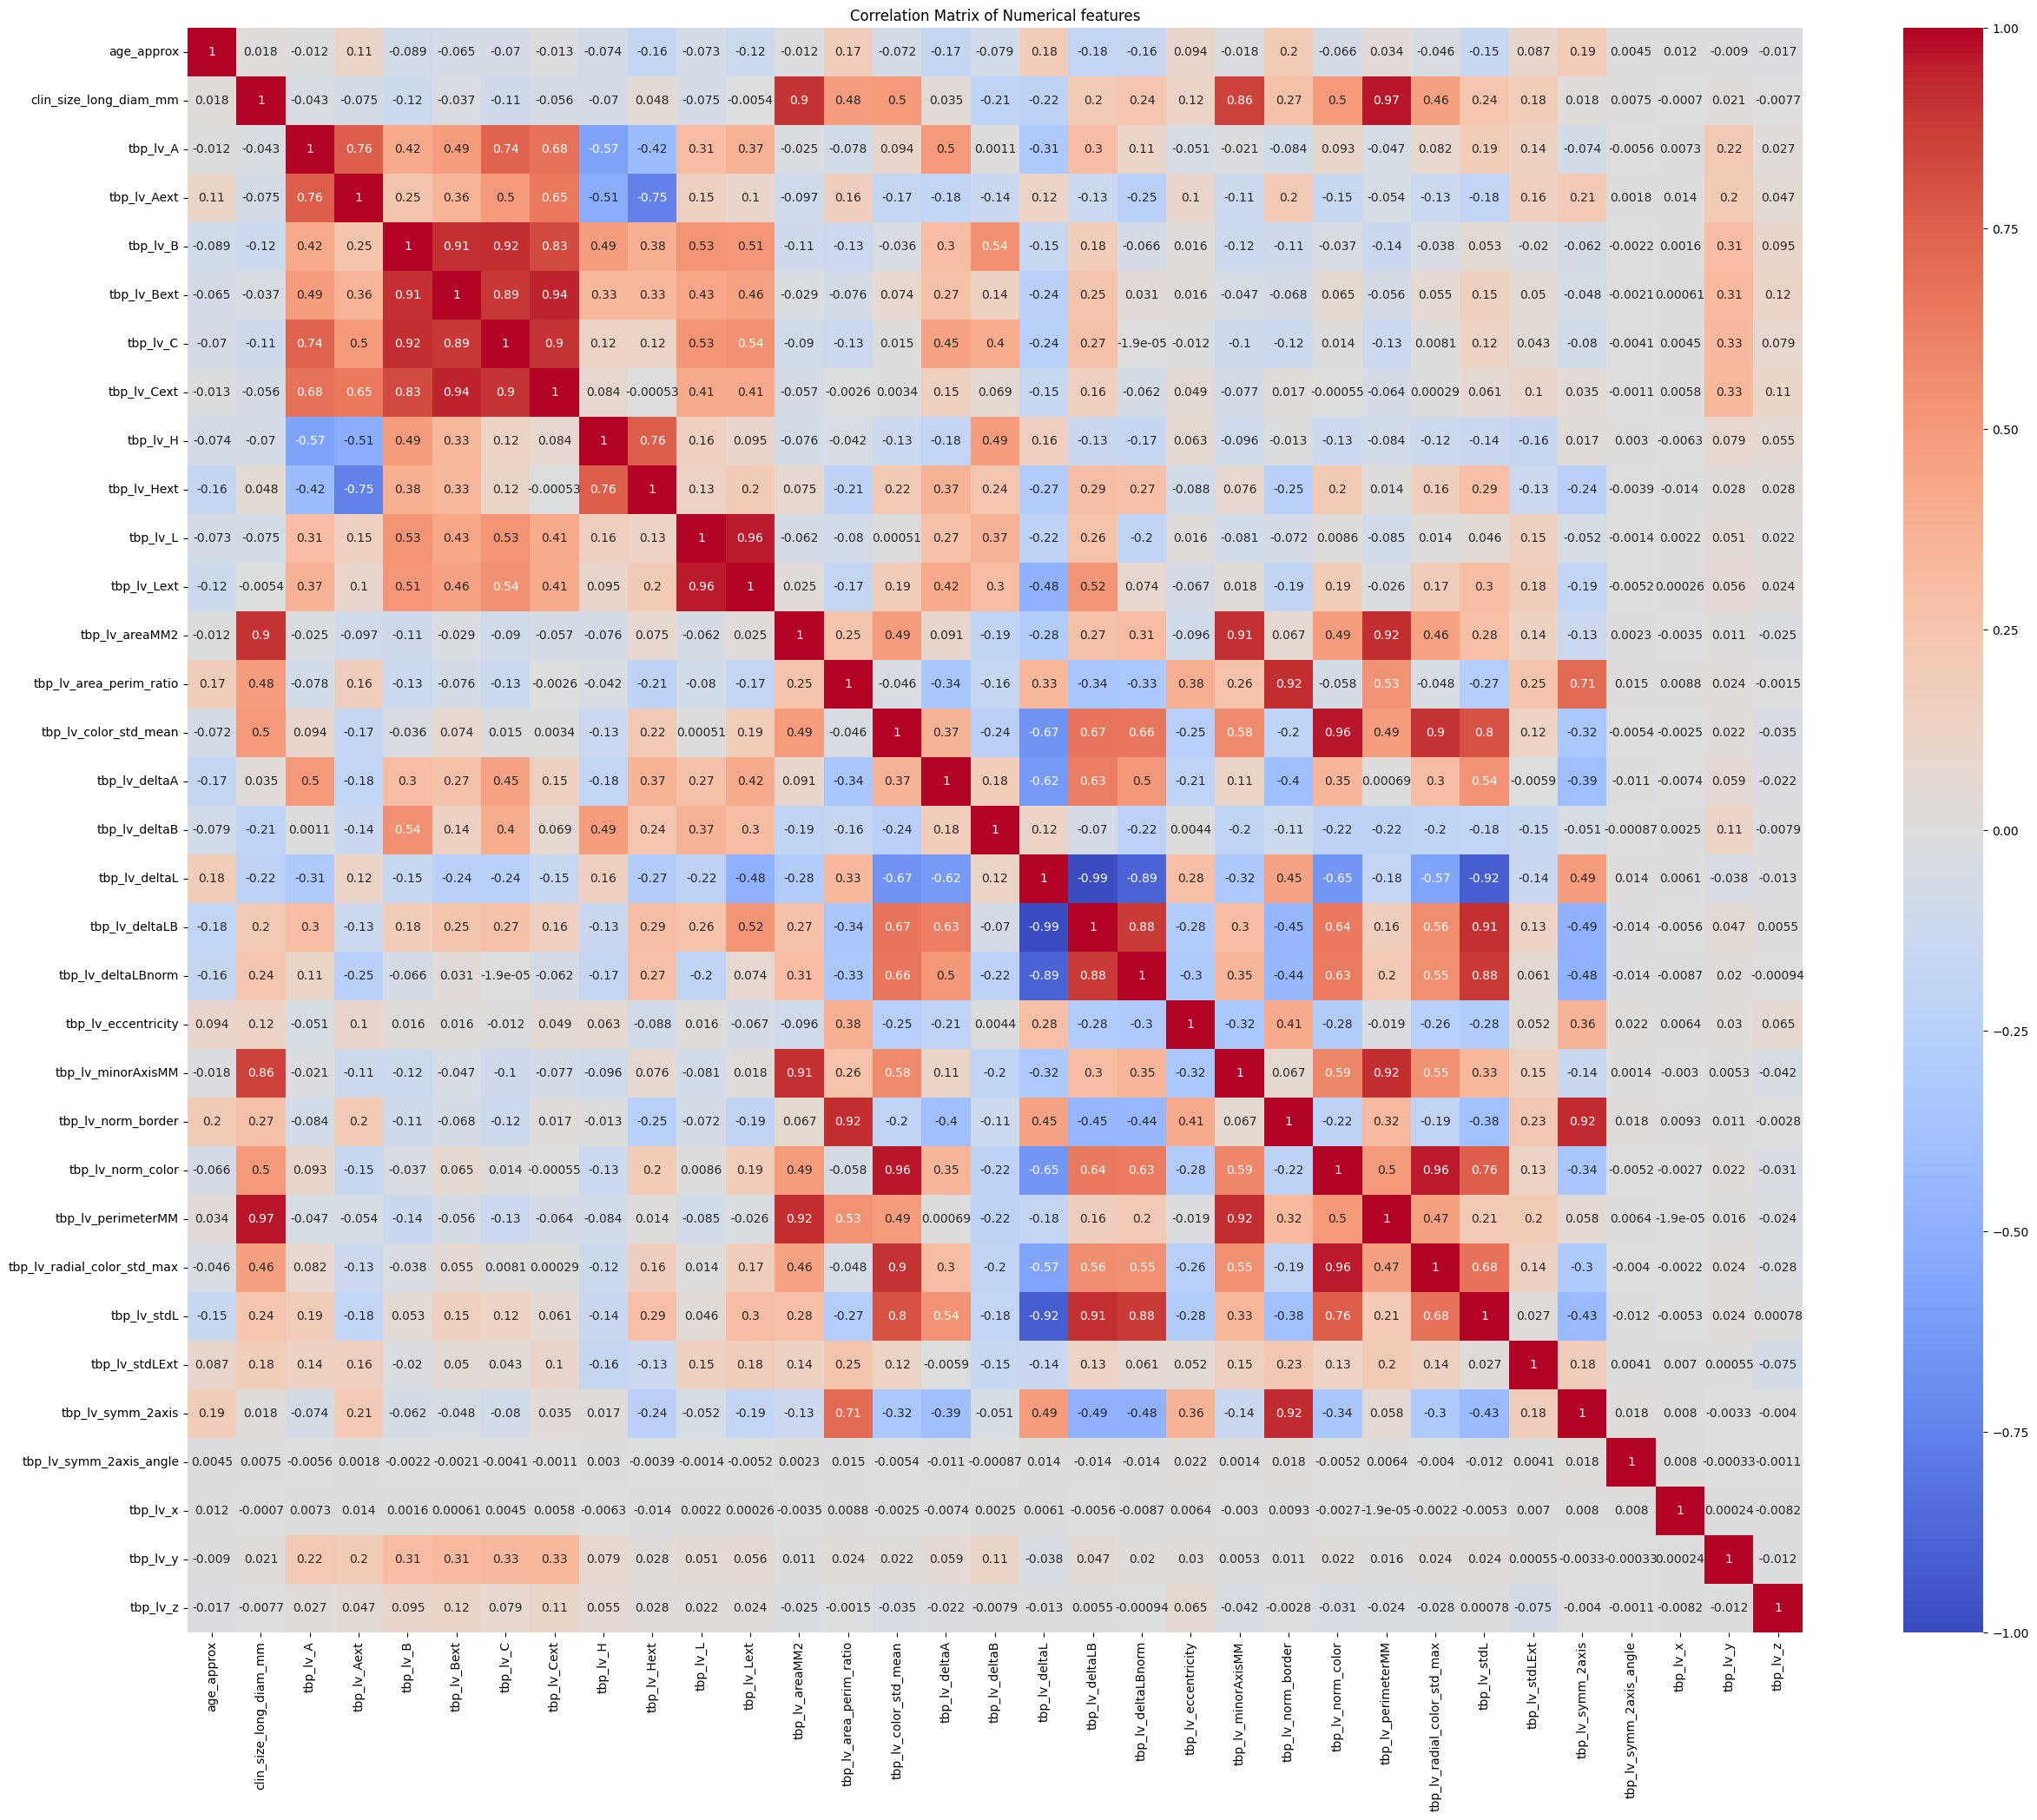

In [87]:
correlation_matrix = X[numerical].corr()
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical features')
plt.show()

###Using very simple method to remove Colinearity

Note: this method is not the particularly best way to deal with colinearity, however due to the scope of this project, we thought using this method would be sufficient

In [88]:
correlated = set()
for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]) > .8:
      correlated.add(correlation_matrix.columns[i])
X_drop = X[numerical].drop(columns = correlated)

print(f"Dropping: {correlated}")
print(f"Remaining columns: {X_drop.columns}")


Dropping: {'tbp_lv_symm_2axis', 'tbp_lv_norm_color', 'tbp_lv_deltaLB', 'tbp_lv_norm_border', 'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_deltaLBnorm', 'tbp_lv_Cext', 'tbp_lv_areaMM2', 'tbp_lv_C', 'tbp_lv_stdL', 'tbp_lv_Bext', 'tbp_lv_Lext'}
Remaining columns: Index(['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_eccentricity',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z'],
      dtype='object')


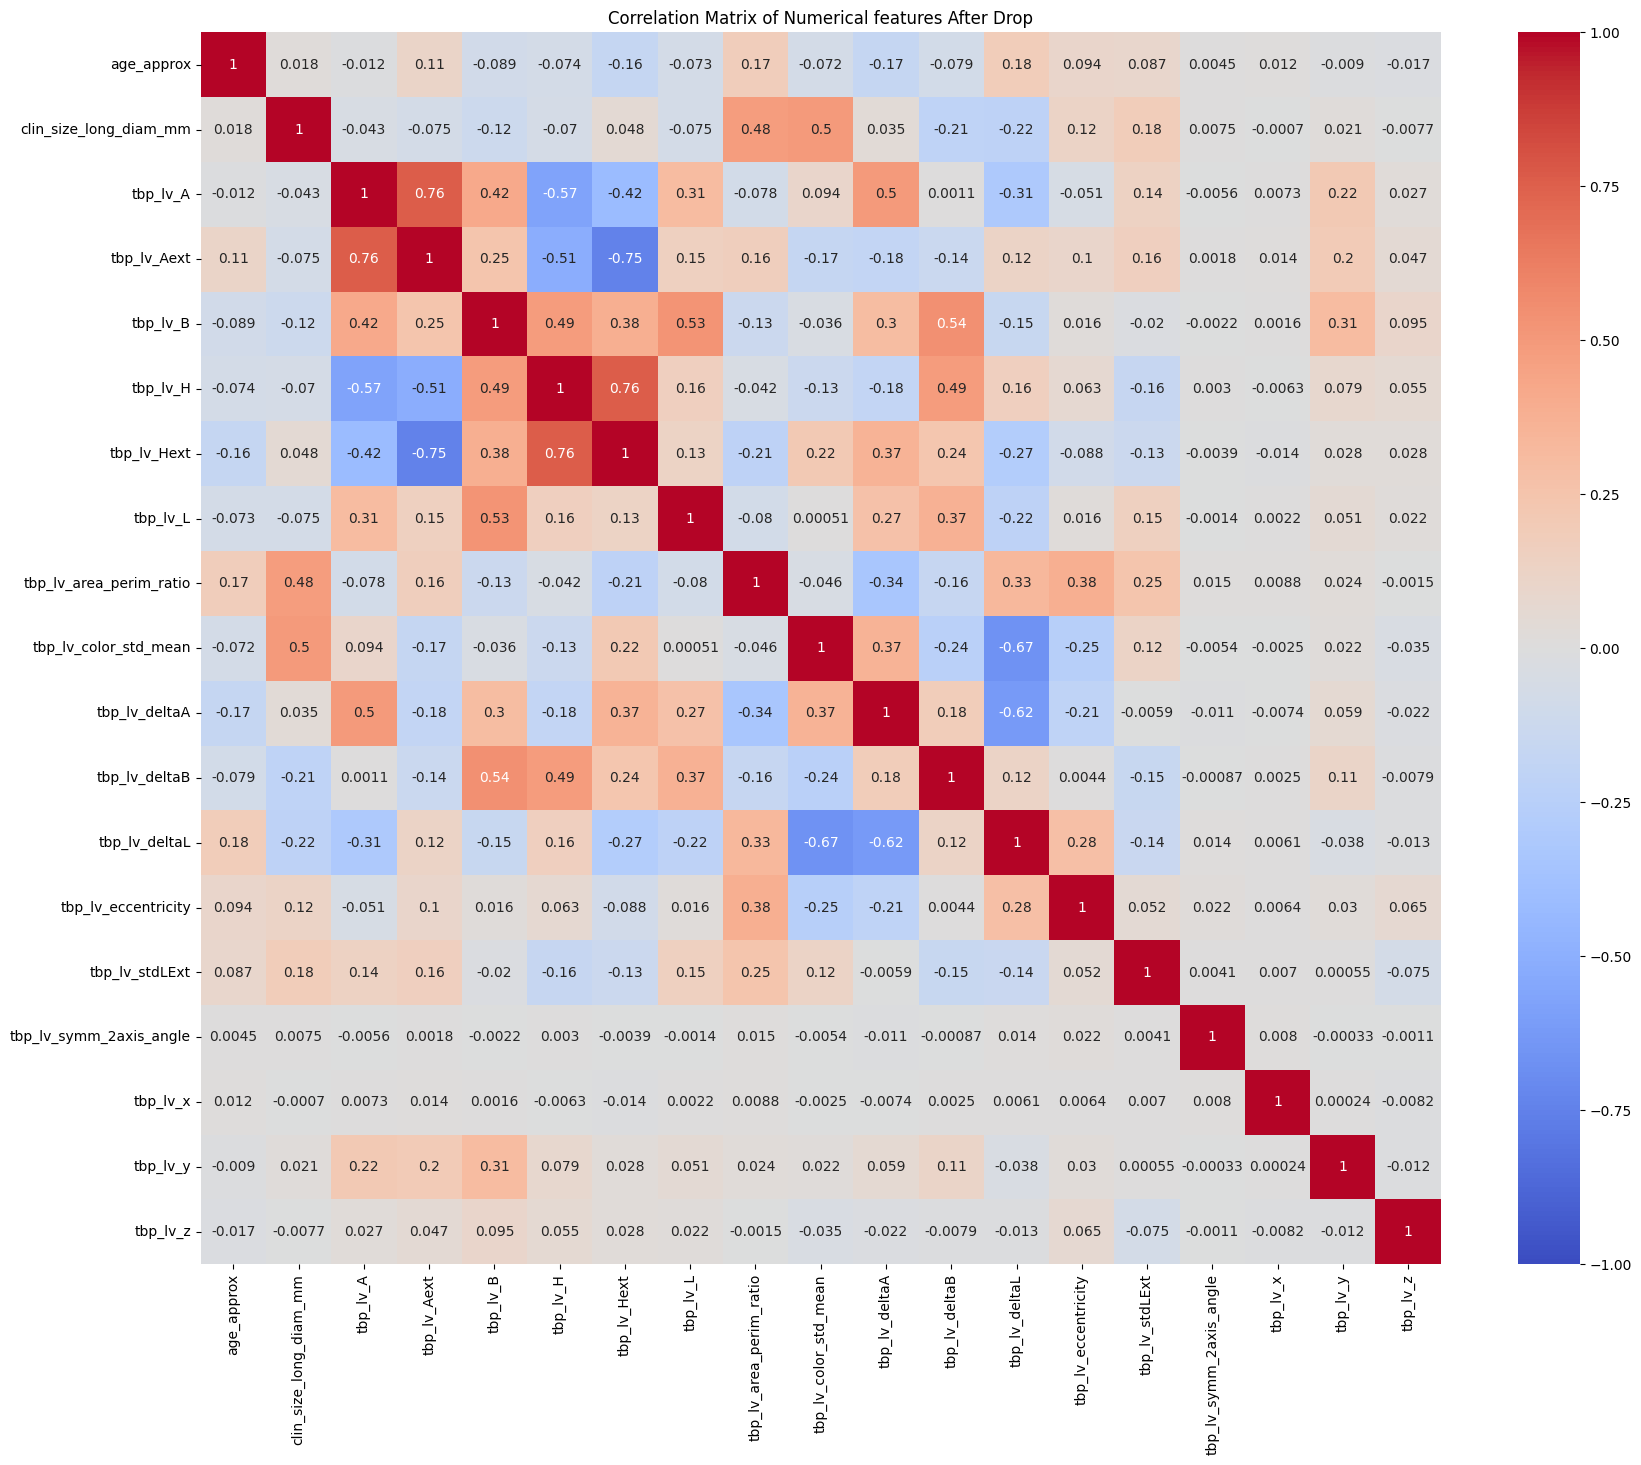

In [89]:
correlation_matrix2 = X_drop.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical features After Drop')
plt.show()

In [90]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)

    ]
)

Updating numerical features based off what we dropped earlier. Also adding back in categorical features to X_drop

In [91]:
new_num = []
for col in X_drop.columns:
  if col in numerical:
    new_num.append(col)

In [92]:
for col in categorical:
  if col not in X_drop.columns:
    X_drop[col] = X[col]

Preprocessor for the removing of colinearity

In [93]:
preprocessor2 = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), new_num),
        ('cat', OneHotEncoder(drop='first'), categorical)

    ]
)

#First attempts on Data with Colinearity within the Data

##Logistic Regression

We apply a sigmoid function in the logistic regression for this initial attempt but we change it to just a linear layer later on

In [94]:
class LogisticRegression(nn.Module):
  def __init__(self, n_features):
    super(LogisticRegression, self).__init__()
    self.linear1 = nn.Linear(n_features, 1)

  def forward(self, x):
    y_pred = torch.sigmoid(self.linear1(x))

    return y_pred

###Initial Attempt using no Class Balancing

In [95]:
X_pre = preprocessor.fit_transform(X)

In [96]:
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [97]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [98]:
n_features = X_train_tensor.shape[1]
model = LogisticRegression(n_features)

Used BCELoss for the loss function for this initial model. Later we change it to BCEWithLogitLoss

In [99]:
lr = .01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [100]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')


epoch: 100, loss: 0.40
epoch: 200, loss: 0.25
epoch: 300, loss: 0.18
epoch: 400, loss: 0.14
epoch: 500, loss: 0.11
epoch: 600, loss: 0.10
epoch: 700, loss: 0.08
epoch: 800, loss: 0.07
epoch: 900, loss: 0.06
epoch: 1000, loss: 0.06


In [101]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_val_tensor)
  y_pred_cls = y_pred.round()
  acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
  print(f'accuracy: {acc:.2f}')

accuracy: 1.00


In [102]:
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val_tensor.detach().numpy()


In [103]:
# classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score       support
Class 0        0.999077  1.000000  0.999539  80138.000000
Class 1        0.000000  0.000000  0.000000     74.000000
accuracy       0.999077  0.999077  0.999077      0.999077
macro avg      0.499539  0.500000  0.499769  80212.000000
weighted avg   0.998156  0.999077  0.998616  80212.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Logistic Regression with Random Under Sampler

In [104]:
X_pre = preprocessor.fit_transform(X)

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [106]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [107]:
#Needed to convert X_train to dense Numpy array from sparse matrix
# X_train_arr = X_train.toarray()
# X_val_arr = X_val.toarray()
X_train_arr = X_train
X_val_arr = X_val

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)


# X_train_tensor = torch.tensor(X_train_arr, dtype=torch.float32).to(device)
# X_val_tensor = torch.tensor(X_val_arr, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

In [109]:
n_features = X_train_tensor.shape[1]
model = LogisticRegression(n_features)

In [110]:
lr = .01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [111]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')


epoch: 100, loss: 0.52
epoch: 200, loss: 0.49
epoch: 300, loss: 0.47
epoch: 400, loss: 0.46
epoch: 500, loss: 0.45
epoch: 600, loss: 0.45
epoch: 700, loss: 0.44
epoch: 800, loss: 0.44
epoch: 900, loss: 0.43
epoch: 1000, loss: 0.43


In [112]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_val_tensor)
  y_pred_cls = y_pred.round()
  acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
  print(f'accuracy: {acc:.2f}')

accuracy: 0.81


In [113]:
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val_tensor.detach().numpy()


In [114]:
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
#classification report
print(report_df)


              precision    recall  f1-score       support
Class 0        0.999846  0.808218  0.893877  80138.000000
Class 1        0.004147  0.864865  0.008254     74.000000
accuracy       0.808271  0.808271  0.808271      0.808271
macro avg      0.501996  0.836542  0.451066  80212.000000
weighted avg   0.998927  0.808271  0.893060  80212.000000


###Slightly different Logistic Regression with Weighting

In [115]:
class LogisticRegression2(nn.Module):
  def __init__(self, n_features):
    super(LogisticRegression2, self).__init__()
    self.linear1 = nn.Linear(n_features, 1)

  def forward(self, x):
    y_pred = self.linear1(x) # This is the change that we made for the forward function of the Logistic Regression. No sigmoid anymore
    return y_pred

In [116]:
X_pre = preprocessor.fit_transform(X)

In [117]:
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [118]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [119]:
n_features = X_train_tensor.shape[1]
model = LogisticRegression2(n_features)

Added pos_weight parameter to penalize

In [120]:
lr = .01
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([1000])) #new thing
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [121]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')


epoch: 100, loss: 0.99
epoch: 200, loss: 0.94
epoch: 300, loss: 0.91
epoch: 400, loss: 0.89
epoch: 500, loss: 0.87
epoch: 600, loss: 0.86
epoch: 700, loss: 0.85
epoch: 800, loss: 0.85
epoch: 900, loss: 0.84
epoch: 1000, loss: 0.84


In [122]:
model.eval()
with torch.inference_mode():
    y_pred = model(X_val_tensor)

    # Since BCEWithLogitsLoss was used, y_pred is in logits form. Apply sigmoid for probabilities.
    y_pred_prob = torch.sigmoid(y_pred)

    # we need to round in order to go from a scale to binary 0/1
    y_pred_cls = y_pred_prob.round()

    # Compare with true values to calculate accuracy
    acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
    print(f'accuracy: {acc:.2f}')


accuracy: 0.83


In [123]:
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
# y_val_pred = y_val_pred.detach().numpy()
# y_val_true = y_val_tensor.detach().numpy()

y_val_pred = y_pred_cls.numpy()
y_val_true = y_val_tensor.numpy()

In [124]:
# classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score       support
Class 0        0.999804  0.826549  0.904959  80138.000000
Class 1        0.004369  0.824324  0.008693     74.000000
accuracy       0.826547  0.826547  0.826547      0.826547
macro avg      0.502087  0.825437  0.456826  80212.000000
weighted avg   0.998885  0.826547  0.904132  80212.000000


###SMOTE with Logistic Regression

In [125]:
X_pre = preprocessor.fit_transform(X)

In [126]:
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [127]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [128]:
X_train_tensor = torch.tensor(X_res, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_res.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

In [129]:
n_features = X_train_tensor.shape[1]
model = LogisticRegression2(n_features)

In [130]:
lr = .01
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([1])) #Can play around with value for pos_weight to test best weight. used 1 for smote
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [131]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')


epoch: 100, loss: 0.52
epoch: 200, loss: 0.49
epoch: 300, loss: 0.47
epoch: 400, loss: 0.46
epoch: 500, loss: 0.45
epoch: 600, loss: 0.44
epoch: 700, loss: 0.44
epoch: 800, loss: 0.43
epoch: 900, loss: 0.43
epoch: 1000, loss: 0.43


In [132]:
model.eval()
with torch.inference_mode():
    y_pred = model(X_val_tensor)

    # Since BCEWithLogitsLoss was used, y_pred is in logits form. Apply sigmoid for probabilities.
    y_pred_prob = torch.sigmoid(y_pred)

    # we need to round in order to go from a scale to binary 0/1
    y_pred_cls = y_pred_prob.round()

    # Compare with true values to calculate accuracy
    acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
    print(f'accuracy: {acc:.2f}')


accuracy: 0.81


In [133]:
# # Make predictions (assuming you have a binary classification problem)
# y_val_pred = (model(X_val_tensor) > 0.5).float()

# # Convert predictions and labels to numpy arrays for sklearn
# y_val_pred = y_val_pred.detach().numpy()
# y_val_true = y_val_tensor.detach().numpy()


In [134]:
y_val_pred = y_pred_cls.numpy()
y_val_true = y_val_tensor.numpy()

In [135]:
# classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score       support
Class 0        0.999799  0.808331  0.893927  80138.000000
Class 1        0.003956  0.824324  0.007874     74.000000
accuracy       0.808345  0.808345  0.808345      0.808345
macro avg      0.501877  0.816327  0.450900  80212.000000
weighted avg   0.998881  0.808345  0.893110  80212.000000


#On the Data with no Colinearity

##A simple Random Forest Classifier and simple XGBoost Attempts

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
X_pre = preprocessor2.fit_transform(X_drop)
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [60]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_val_pred = random_forest_model.predict(X_val)
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     80138
     Class 1       0.00      0.00      0.00        74

    accuracy                           1.00     80212
   macro avg       0.50      0.50      0.50     80212
weighted avg       1.00      1.00      1.00     80212



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

random_forest_model2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 9999}) #Can mess with class weights
random_forest_model2.fit(X_resampled, y_resampled)

y_val_pred = random_forest_model2.predict(X_val)
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)


              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     80138
     Class 1       0.29      0.03      0.05        74

    accuracy                           1.00     80212
   macro avg       0.64      0.51      0.52     80212
weighted avg       1.00      1.00      1.00     80212



In [62]:
import xgboost as xgb

In [63]:
X_pre = preprocessor2.fit_transform(X_drop)
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

In [64]:
d_train = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [65]:
# Set up parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',
    'scale_pos_weight': 1000,         # Adjust this based on the imbalance ratio (positive to negative class)
    'eta': 0.1,                      # Learning rate (didnt adjust)
    'max_depth': 5,                  # Maximum depth of a tree (can adjust)
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the model
model = xgb.train(
    params,
    d_train,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    verbose_eval=True
)


# Make predictions on the validation set
y_val_pred_proba = model.predict(dval)
y_val_pred = (y_val_pred_proba > 0.4).astype(int)  # Convert probabilities to binary predictions

[0]	validation-logloss:0.63037
[1]	validation-logloss:0.58453
[2]	validation-logloss:0.54417
[3]	validation-logloss:0.50742
[4]	validation-logloss:0.48037
[5]	validation-logloss:0.45054
[6]	validation-logloss:0.42663
[7]	validation-logloss:0.40504
[8]	validation-logloss:0.38329
[9]	validation-logloss:0.36555
[10]	validation-logloss:0.34849
[11]	validation-logloss:0.33340
[12]	validation-logloss:0.32103
[13]	validation-logloss:0.31041
[14]	validation-logloss:0.30024
[15]	validation-logloss:0.28865
[16]	validation-logloss:0.27693
[17]	validation-logloss:0.26942
[18]	validation-logloss:0.26065
[19]	validation-logloss:0.25297
[20]	validation-logloss:0.24669
[21]	validation-logloss:0.24062
[22]	validation-logloss:0.23626
[23]	validation-logloss:0.23133
[24]	validation-logloss:0.22611
[25]	validation-logloss:0.21890
[26]	validation-logloss:0.21441
[27]	validation-logloss:0.21042
[28]	validation-logloss:0.20827
[29]	validation-logloss:0.20432
[30]	validation-logloss:0.19890
[31]	validation-lo

In [66]:
# classification report
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)


              precision    recall  f1-score   support

     Class 0       1.00      0.97      0.98     80138
     Class 1       0.02      0.64      0.03        74

    accuracy                           0.96     80212
   macro avg       0.51      0.80      0.51     80212
weighted avg       1.00      0.96      0.98     80212



In [67]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

dtrain_resampled = xgb.DMatrix(X_resampled, label=y_resampled)
dval = xgb.DMatrix(X_val, label=y_val)


In [68]:
# Set up parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',
    'scale_pos_weight': 1000,         # Adjust this based on the imbalance ratio (positive to negative class)
    'eta': 0.1,                      # Learning rate (didnt adjust)
    'max_depth': 5,                  # Maximum depth of a tree (can adjust)
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the model
model = xgb.train(
    params,
    dtrain_resampled,
    num_boost_round=100,
    evals=[(dval, 'validation')],
    early_stopping_rounds=100,
    verbose_eval=True
)


# Make predictions on the validation set
y_val_pred_proba = model.predict(dval)
y_val_pred = (y_val_pred_proba > 0.4).astype(int)  # make into binary


[0]	validation-logloss:2.13628
[1]	validation-logloss:2.18615
[2]	validation-logloss:2.23578
[3]	validation-logloss:2.29700
[4]	validation-logloss:2.36520
[5]	validation-logloss:2.43499
[6]	validation-logloss:2.49960
[7]	validation-logloss:2.52613
[8]	validation-logloss:2.51772
[9]	validation-logloss:2.57279
[10]	validation-logloss:2.60506
[11]	validation-logloss:2.59193
[12]	validation-logloss:2.61025
[13]	validation-logloss:2.65776
[14]	validation-logloss:2.69968
[15]	validation-logloss:2.74086
[16]	validation-logloss:2.77765
[17]	validation-logloss:2.75517
[18]	validation-logloss:2.74001
[19]	validation-logloss:2.76747
[20]	validation-logloss:2.76320
[21]	validation-logloss:2.78110
[22]	validation-logloss:2.80541
[23]	validation-logloss:2.82863
[24]	validation-logloss:2.80266
[25]	validation-logloss:2.76159
[26]	validation-logloss:2.72858
[27]	validation-logloss:2.65843
[28]	validation-logloss:2.64663
[29]	validation-logloss:2.62353
[30]	validation-logloss:2.64071
[31]	validation-lo

In [69]:
# classification report
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])
print(report)


              precision    recall  f1-score   support

     Class 0       1.00      0.70      0.83     80138
     Class 1       0.00      0.81      0.01        74

    accuracy                           0.70     80212
   macro avg       0.50      0.76      0.42     80212
weighted avg       1.00      0.70      0.82     80212



##Back to Logistic Regression

In [70]:
X_pre = preprocessor2.fit_transform(X_drop)
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

n_features = X_train_tensor.shape[1]
model = LogisticRegression(n_features)

lr = .01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)



In [71]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')

epoch: 100, loss: 0.39
epoch: 200, loss: 0.25
epoch: 300, loss: 0.18
epoch: 400, loss: 0.14
epoch: 500, loss: 0.11
epoch: 600, loss: 0.10
epoch: 700, loss: 0.08
epoch: 800, loss: 0.07
epoch: 900, loss: 0.07
epoch: 1000, loss: 0.06


In [72]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_val_tensor)
  y_pred_cls = y_pred.round()
  acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
  print(f'accuracy: {acc:.2f}')

accuracy: 1.00


In [73]:
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val_tensor.detach().numpy()

# classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score       support
Class 0        0.999077  1.000000  0.999539  80138.000000
Class 1        0.000000  0.000000  0.000000     74.000000
accuracy       0.999077  0.999077  0.999077      0.999077
macro avg      0.499539  0.500000  0.499769  80212.000000
weighted avg   0.998156  0.999077  0.998616  80212.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Now with the second Logistic Regression, other loss function, and pos_weight parameter

In [74]:
X_pre = preprocessor2.fit_transform(X_drop)
X_train, X_val, y_train, y_val = train_test_split(X_pre, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

n_features = X_train_tensor.shape[1]
model = LogisticRegression2(n_features)

lr = .01
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor ([1000]))
optimizer = torch.optim.SGD(model.parameters(), lr = lr)



In [75]:
epochs = 1000
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train_tensor)
  loss = criterion(y_pred, y_train_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  if (epoch+1)%100 == 0:
    print(f'epoch: {epoch+1}, loss: {loss.item():.2f}')

epoch: 100, loss: 1.01
epoch: 200, loss: 0.96
epoch: 300, loss: 0.93
epoch: 400, loss: 0.91
epoch: 500, loss: 0.90
epoch: 600, loss: 0.90
epoch: 700, loss: 0.89
epoch: 800, loss: 0.88
epoch: 900, loss: 0.88
epoch: 1000, loss: 0.88


In [76]:
model.eval()
with torch.inference_mode():
    y_pred = model(X_val_tensor)

    # Since BCEWithLogitsLoss was used, y_pred is in logits form. Apply sigmoid for probabilities.
    y_pred_prob = torch.sigmoid(y_pred)

    # we need to round in order to go from a scale to binary 0/1
    y_pred_cls = y_pred_prob.round()

    # Compare with true values to calculate accuracy
    acc = y_pred_cls.eq(y_val_tensor).sum() / float(y_val_tensor.shape[0])
    print(f'accuracy: {acc:.2f}')


accuracy: 0.81


In [77]:
# Make predictions (assuming you have a binary classification problem)
y_val_pred = (model(X_val_tensor) > 0.5).float()

# Convert predictions and labels to numpy arrays for sklearn
y_val_pred = y_val_pred.detach().numpy()
y_val_true = y_val_tensor.detach().numpy()

# classification report
report = classification_report(y_val_true, y_val_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score       support
Class 0        0.999692  0.889990  0.941656  80138.000000
Class 1        0.005864  0.702703  0.011631     74.000000
accuracy       0.889817  0.889817  0.889817      0.889817
macro avg      0.502778  0.796346  0.476643  80212.000000
weighted avg   0.998775  0.889817  0.940798  80212.000000
